In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/02_outlet.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
config['domain']

{'adjustParticle': False, 'adjustDomain': False, 'dim': 2, 'periodic': True}

In [4]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 1000

config['domain']['minExtent'] = [-2.2,-1.2]
config['domain']['maxExtent'] =  [2.2,1.2]
config['domain']['periodic'] = False

config['boundary']['active'] = True

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


Re = 999.9998168945312, $\nu_{sph} = 0.0040000006556510925$, $\alpha = 0.01798984408378601$


In [5]:
config['particle']['support'] * 2

tensor(0.1423, device='cuda:0')

In [6]:
# from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

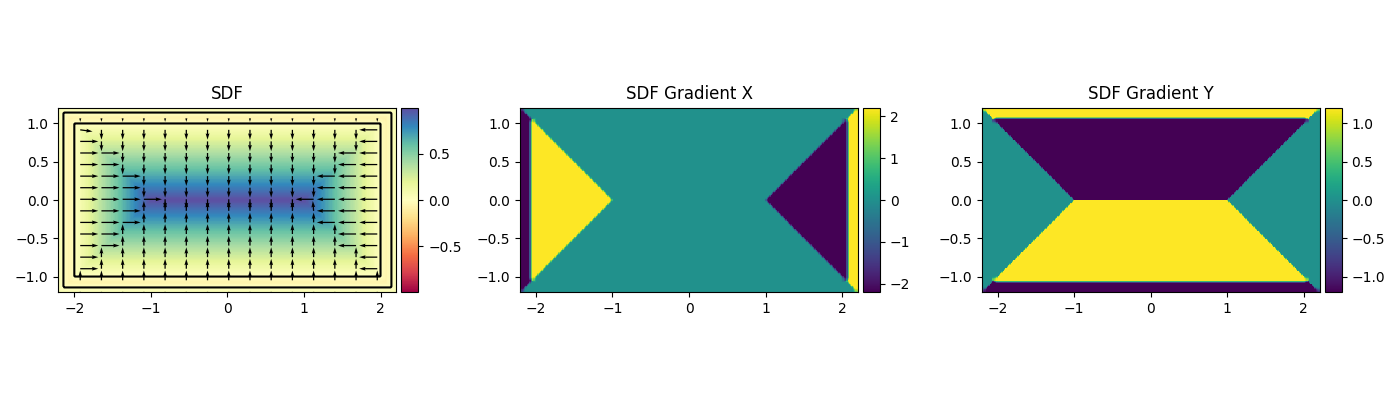

In [7]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('polygon')['function'](points, torch.tensor([[0.5,0.5],[0.5,-0.5],[-0.5,-0.5],[-0.5,0.5]]))
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 2,1 + config['particle']['support'] * 2]).to(points.device))


translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)

outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
sdf = operatorDict['invert'](sdf)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sdf
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [8]:
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour
# from diffSPH.v2.modules.divergence import computeDivergence

# def find_contour(f, minExtent, maxExtent, nGrid, level = 0):
#     contours = measure.find_contours(f.numpy(), level)
#     for ic in range(len(contours)):
#         contours[ic][:,0] = (contours[ic][:,0]) / (f.shape[0] - 1) * (maxExtent[0] - minExtent[0]).numpy() + minExtent[0].numpy()
#         contours[ic][:,1] = (contours[ic][:,1]) / (f.shape[0] - 1) * (maxExtent[1] - minExtent[1]).numpy() + minExtent[1].numpy()
#     return contours

In [9]:
ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([2,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([2 + config['particle']['support'] * 2,1 + config['particle']['support'] * 2]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](sdf)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/2,1/2]).to(points.device))
fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    {
        'sdf': boundary_sdf,
        'type': 'boundary',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [boundary_sdf])[0],
        'contour': find_contour(boundary_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)

# # plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,0])


In [10]:


# # sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/2,1]).to(points.device))
# # outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# # fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

# print(outletSDF(torch.clone(points)).min())
# plotSDF(outletSDF(torch.clone(points),), X, Y, 2, 2)

In [11]:
from diffSPH.v2.plotting import setPlotBaseAttributes
from diffSPH.v2.plotting import setPlotBaseAttributes

def processOutlet(region, config, perennialState):
    outletSDF = region['sdf']
    dist = outletSDF(perennialState['fluid']['positions'])
    mask = dist < 0
    reducedIndices = torch.arange(perennialState['fluid']['positions'].shape[0], device = perennialState['fluid']['positions'].device, dtype =  torch.int64)[~mask]

    if mask.sum() == 0:
        return
    print(f'Outlet: {mask.sum()} particles removed')
    print('Current particles:', perennialState['fluid']['positions'].shape[0])
    print(reducedIndices.shape, reducedIndices)

    for k in perennialState['fluid'].keys():
        if isinstance(perennialState['fluid'][k], torch.Tensor):
            perennialState['fluid'][k] = perennialState['fluid'][k][reducedIndices]
    
    perennialState['fluid']['numParticles'] = perennialState['fluid']['positions'].shape[0]

def processForcing(region, config, perennialState):
    outletSDF = region['sdf']
    dist = outletSDF(perennialState['fluid']['positions'])
    mask = dist < 0
    reducedIndices = torch.arange(perennialState['fluid']['positions'].shape[0], device = perennialState['fluid']['positions'].device, dtype =  torch.int64)[mask]

    if mask.sum() == 0:
        return
    
    perennialState['fluid']['velocities'][reducedIndices,0] = region['velocity'][0]
    perennialState['fluid']['velocities'][reducedIndices,1] = region['velocity'][1]


def plotRegions(regions, axis):
    for region in regions:
        # visualizeParticles(region['particles'], axis[0,0], config)
        for ic, contour in enumerate(region['contour']):
            color = 'black'
            style = '-'
            if region['type'] == 'inlet':
                color = 'green'
                style = '--'
            if region['type'] == 'forcing':
                color = 'blue'
                style = ':'
            if region['type'] == 'outlet':
                color = 'red'
                style = ':'
            if region['type'] == 'mirror':
                color = 'black'
                style = ':'
            if region['type'] == 'boundary':
                color = 'grey'
                style = ':'
            if region['type'] == 'fluid':
                color = 'purple'
                style = ':'
            # axis[0,0].plot(contour[:,0], contour[:,1], color=color)
            axis.plot(contour[:,0], contour[:,1], color = color, ls = style, label = region['type'] if ic == 0 else None)
        if region['type'] == 'inlet':
            axis.scatter(region['particles']['positions'][:,0].detach().cpu().numpy(), region['particles']['positions'][:,1].detach().cpu().numpy(), color = 'green', s = 1)
    # axis[0,0].legend()

def mergeStates(oldState, newState):
    for key in oldState.keys():
        if not isinstance(oldState[key], torch.Tensor):
            continue
        if key in newState.keys():
            # print(f'Merging key {key} with shape {oldState[key].shape} and {newState[key].shape}')
            oldState[key] = torch.cat([oldState[key], newState[key]], dim = 0)
        else:
            # print(f'Key {key} not found in newState')

            pseudoVar = torch.zeros([newState['numParticles'], *oldState[key].shape[1:]], dtype = oldState[key].dtype, device = oldState[key].device)
            # print(pseudoVar.shape)

            oldState[key] = torch.cat([oldState[key], pseudoVar], dim = 0)
    oldState['numParticles'] = oldState['positions'].shape[0]#.detach().cpu().item()
    return oldState

from diffSPH.v2.finiteDifference import continuousGradient, centralDifferenceStencil

def buildOutletGhostParticles(regions, perennialState, config):
    ghostState = None

    for region in regions:
        if region['type'] != 'mirror':
            continue
            # ghostState = copy.deepcopy(region)
        outletSDF = region['sdf']
        dist = outletSDF(perennialState['fluid']['positions'])
        mask = dist < 0
        reducedIndices = torch.arange(perennialState['fluid']['positions'].shape[0], device = perennialState['fluid']['positions'].device, dtype =  torch.int64)[mask]

        if mask.sum() == 0: 
            continue

    # axis[0,0].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), s = 1, c = mask)

        i = reducedIndices
        j = torch.arange(i.shape[0], device = i.device, dtype = i.dtype)
        pos = perennialState['fluid']['positions'][reducedIndices]

        dist = outletSDF(pos)

        grad = continuousGradient(outletSDF, pos, stencil = centralDifferenceStencil(1,2), dx = config['particle']['support']*0.01, order = 1)
        grad = grad / (torch.linalg.norm(grad, dim = 1, keepdim = True) + 1e-7)
        ghostPos = pos - 2 * dist[:,None] * grad

        if ghostState is None:
            ghostState = {
                'positions': ghostPos,
                'velocities': torch.zeros_like(ghostPos),
                'supports': torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['particle']['support'],
                'densities' : torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['fluid']['rho0'],
                'masses': torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['particle']['volume'] * config['fluid']['rho0'],
                'index': j,
                'fluidIndex': i,
                'numParticles': j.shape[0],
                'sdf_dist': dist,
                'sdf_grad': grad
            }
        else:
            ghostState['positions'] = torch.cat([ghostState['positions'], ghostPos], dim = 0)
            ghostState['velocities'] = torch.cat([ghostState['velocities'], torch.zeros_like(ghostPos)], dim = 0)
            ghostState['supports'] = torch.cat([ghostState['supports'], torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['particle']['support']], dim = 0)
            ghostState['densities'] = torch.cat([ghostState['densities'], torch.ones(ghostPos.shape[0], device = ghostPos.device) * config['fluid']['rho0']], dim = 0)
            ghostState['index'] = torch.cat([ghostState['index'], j], dim = 0)
            ghostState['fluidIndex'] = torch.cat([ghostState['fluidIndex'], i], dim = 0)
            ghostState['numParticles'] = ghostState['positions'].shape[0]
            ghostState['sdf_dist'] = torch.cat([ghostState['sdf_dist'], dist], dim = 0)
            ghostState['sdf_grad'] = torch.cat([ghostState['sdf_grad'], grad], dim = 0)

    if ghostState is None:
        return None

    gridConfig = {
        'domain': config['domain'],
        'simulation': {
            'supportScheme': 'scatter'
        },
        'neighborhood':{
            'algorithm': 'compact',
            'scheme': 'compact',
            'verletScale': 1.0
        },
        'kernel': config['kernel']
    }
            
    # ghostState['neighborhood'] = neighborSearch(ghostState, perennialState['fluid'], gridConfig, computeKernels=False)
    ghostState['neighborhood'] = neighborSearch(ghostState, perennialState['fluid'], gridConfig, computeKernels=True)
    _, ghostState['numNeighbors'] = countUniqueEntries(ghostState['neighborhood']['indices'][0], ghostState['positions'])

    return ghostState

from diffSPH.v2.sphOps import sphOperationStates

def adjunctMatrix(M, c, i):
    res = torch.empty_like(M)

    for j in range(c.shape[1]):
        res[:,:,j] = c if j == i else M[:,:,j]
    return res
def LiuLiuConsistent(ghostState, fluidState, q):
    b_scalar = sphOperationStates(ghostState, fluidState, (ghostState['masses'] *0, q), operation = 'interpolate', neighborhood = ghostState['neighborhood'])
    b_grad = sphOperationStates(ghostState, fluidState, (ghostState['masses'] *0, q), operation = 'gradient', neighborhood = ghostState['neighborhood'], gradientMode = 'naive')
    b = torch.cat([b_scalar.view(-1,1), b_grad], dim = 1)

    xij = -ghostState['neighborhood']['vectors'] * ghostState['neighborhood']['distances'].view(-1,1) * config['particle']['support']
    M_0 = sphOperationStates(ghostState, fluidState, (torch.ones_like(q), torch.ones_like(q)), operation = 'interpolate', neighborhood = ghostState['neighborhood'])
    M_grad = sphOperationStates(ghostState, fluidState, (torch.ones_like(q), torch.ones_like(q)), operation = 'gradient', neighborhood = ghostState['neighborhood'], gradientMode = 'naive')

    M_x = sphOperationStates(ghostState, fluidState, xij, operation = 'interpolate', neighborhood = ghostState['neighborhood'])
    M_x_grad = sphOperationStates(ghostState, fluidState, xij, operation = 'gradient', neighborhood = ghostState['neighborhood'], gradientMode = 'naive')

    M = []
    M.append(torch.cat([M_0.view(-1,1), M_x], dim = 1))
    for i in range(M_grad.shape[1]):
        M.append(torch.cat([M_grad[:,i].view(-1,1), M_x_grad[:,i,:]], dim = 1))
        

    M = torch.stack([row.unsqueeze(2) for row in M], dim = 2)[:,:,:,0].mT
    # solution = torch.linalg.solve(M, b)

    # d0 = torch.linalg.det(M)
    d0 = torch.linalg.det(M)
    adjunctMatrices = [torch.linalg.det(adjunctMatrix(M, b, i)) for i in range(M.shape[1])]
    solution = torch.stack([adj/(d0 + 1e-7) for adj in adjunctMatrices], dim = 1)

    # dets = []

    return solution, M, b

def processInlet(perennialState, emitter):
    emitterState = emitter['particles']

    emitterNeighborhood = neighborSearch(emitterState, perennialState['fluid'], config, computeKernels=False)

    distance = emitterNeighborhood['distances']
    i = emitterNeighborhood['indices'][0]
    newDistance = distance.new_ones(emitterState['numParticles'], dtype = config['compute']['dtype']) #* config['particle']['support']
    minDistance = newDistance.index_reduce_(dim = 0, index = i, source = distance, include_self = False, reduce = 'amin')

    emitterMask = minDistance >= config['particle']['dx'] / config['particle']['support']

    newPositions = emitterState['positions'][emitterMask].to(config['compute']['device'])
    newParticleState = {
        'numParticles': newPositions.shape[0],#.detach().cpu(),
        'positions': newPositions,

        'areas': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'],
        'masses': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'] * config['fluid']['rho0'],
        'densities': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['fluid']['rho0'],
        'supports': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['support'],

        'pressures': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),
        'divergence': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),

        'velocities': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
        'accelerations': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
        'index': torch.arange(newPositions.shape[0], dtype = torch.int32, device = config['compute']['device']) + perennialState['uidCounter'],
        # 'neighbors': None,
    }
    newParticleState['velocities'][:,0] = emitter['velocity'][0]
    newParticleState['velocities'][:,1] = emitter['velocity'][1]
    
    # print(f'Adding {newParticleState["numParticles"]} particles (total {perennialState["fluid"]["numParticles"] + newParticleState["numParticles"]})')
    perennialState['uidCounter'] += newParticleState['numParticles']

    perennialState['fluid'] = mergeStates(perennialState['fluid'], newParticleState)

In [12]:
from diffSPH.v2.plotting import setPlotBaseAttributes

# fig, axis = plt.subplots(1, 2, figsize = (14,5), squeeze = False)

# setPlotBaseAttributes(axis[0,0], config)
# setPlotBaseAttributes(axis[0,1], config)

# # def plotRegions(regions, axis):
# #     for region in regions:
# #         # visualizeParticles(region['particles'], axis[0,0], config)
# #         for ic, contour in enumerate(region['contour']):
# #             color = 'black'
# #             style = '-'
# #             if region['type'] == 'inlet':
# #                 color = 'green'
# #                 style = '--'
# #             if region['type'] == 'forcing':
# #                 color = 'blue'
# #                 style = ':'
# #             if region['type'] == 'outlet':
# #                 color = 'red'
# #                 style = ':'
# #             if region['type'] == 'mirror':
# #                 color = 'black'
# #                 style = ':'
# #             # axis[0,0].plot(contour[:,0], contour[:,1], color=color)
# #             axis.plot(contour[:,0], contour[:,1], color = color, ls = style, label = region['type'] if ic == 0 else None)
# #         if region['type'] == 'inlet':
# #             axis.scatter(region['particles']['positions'][:,0].detach().cpu().numpy(), region['particles']['positions'][:,1].detach().cpu().numpy(), color = 'green', s = 1)
#     # axis[0,0].legend()

# plotRegions(regions, axis[0,0])
# fig.tight_layout()

#     # axis[0,0].contour(X.numpy(), Y.numpy(), fx.numpy(), levels=[0], colors='black')

In [13]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict
from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid, visualizeParticleQuantity

# particleState, mask = sampleParticles(config, sdfs = [sdf])

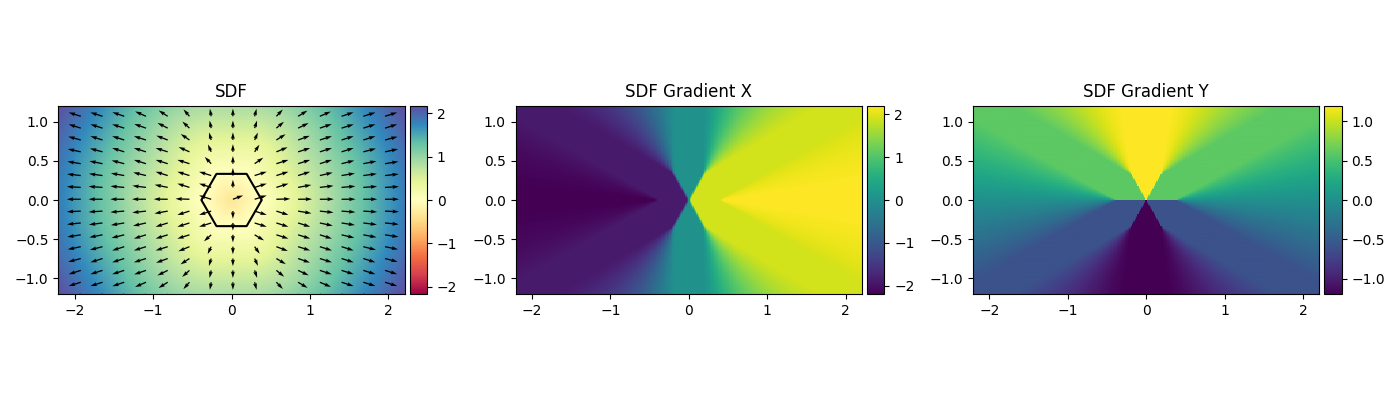

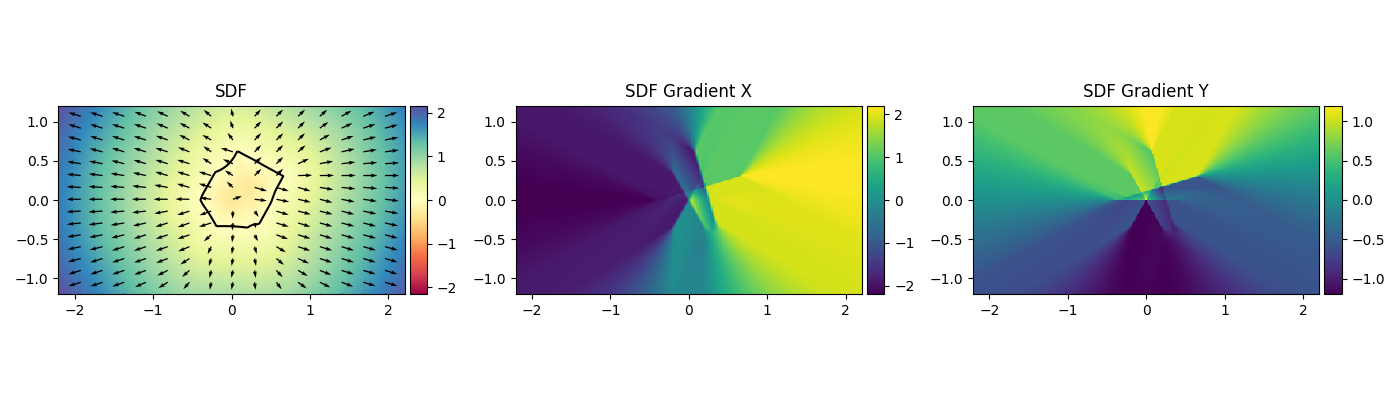

In [14]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 1/3)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
fluid_sdf = sphere_a
plotSDF(fluid_sdf(torch.clone(points.to('cuda')),), X.to('cuda'), Y.to('cuda'), 2, 2)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([2,1/8]).to(points.device))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.0,-1/2 - 1/8]))
boundary_sdf = sdf
plotSDF(boundary_sdf(torch.clone(points),), X, Y, 2, 2)

In [15]:
print(config['gravity'])
config['gravity']['active'] = True

{'active': False, 'direction': [0, -1, 0], 'magnitude': 9.81, 'gravityMode': 'constant', 'potentialOrigin': [0, 0, 0]}


In [16]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs



# particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'inlet'])
particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'fluid'])

# sdf = 
boundaryState = processBoundarySDFs(particleState, config, [region['sdf'] for region in regions if region['type'] == 'boundary'], 'regular')

In [17]:

s = 2
perennialState = {
    'fluid': copy.deepcopy(particleState),
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
    'uidCounter': particleState['numParticles']
}

u = 1
# perennialState['fluid']['velocities'][:,0] = u

In [18]:

def buildBoundaryGhostParticles(perennialState, config):
    boundaryParticlePositions = perennialState['boundary']['positions'] 
    ghostParticlePositions = boundaryParticlePositions - 2 * perennialState['boundary']['distances'].view(-1,1) * perennialState['boundary']['normals'] 

    boundaryGhostState = {
        'positions': ghostParticlePositions,
        'areas': perennialState['boundary']['areas'],
        'masses': perennialState['boundary']['masses'],
        'densities': perennialState['boundary']['densities'],
        'supports': perennialState['boundary']['supports'],
        'velocities': perennialState['boundary']['velocities'],
        'numParticles': ghostParticlePositions.shape[0],
    }
    boundaryGhostState['neighborhood'] = neighborSearch(boundaryGhostState, perennialState['fluid'], config, computeKernels=True)
    _, boundaryGhostState['numNeighbors'] = countUniqueEntries(boundaryGhostState['neighborhood']['indices'][0], ghostParticlePositions)

    return boundaryGhostState


def mDBCDensity(perennialState, config):
    boundaryGhostState = perennialState['boundaryGhost']

    shepardNominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], None, operation = 'density', neighborhood = boundaryGhostState['neighborhood'])
    shepardDenominator = sphOperationStates(boundaryGhostState, perennialState['fluid'], 
            (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])),
            # (boundaryGhostState['densities'] / boundaryGhostState['masses'], perennialState['fluid']['densities'] / perennialState['fluid']['masses']),
              operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])

    shepardDensity = shepardNominator / (shepardDenominator + 1e-7)

    gradientSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (boundaryGhostState['densities'], perennialState['fluid']['densities']), operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

    b = torch.hstack((shepardNominator[:,None], gradientSum))

    volumeSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])), operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])
    volumeGradSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], (torch.ones_like(boundaryGhostState['masses']), torch.ones_like(perennialState['fluid']['masses'])), operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

    xij = -boundaryGhostState['neighborhood']['vectors'] * boundaryGhostState['neighborhood']['distances'].view(-1,1) * config['particle']['support']

    positionSum = sphOperationStates(boundaryGhostState, perennialState['fluid'], xij, operation = 'interpolate', neighborhood = boundaryGhostState['neighborhood'])
    positionMatrix = sphOperationStates(boundaryGhostState, perennialState['fluid'], xij, operation = 'gradient', neighborhood = boundaryGhostState['neighborhood'], gradientMode = 'naive')

    A_g = torch.zeros((boundaryGhostState['numParticles'], 3, 3), dtype = xij.dtype, device = xij.device)

    A_g[:,0,0] = volumeSum
    A_g[:,1,0] = volumeGradSum[:,0]
    A_g[:,2,0] = volumeGradSum[:,1]

    A_g[:,0,1] = positionSum[:,0]
    A_g[:,0,2] = positionSum[:,1]

    A_g[:,1,1] = positionMatrix[:,0,0]
    A_g[:,1,2] = positionMatrix[:,0,1]
    A_g[:,2,1] = positionMatrix[:,1,0]
    A_g[:,2,2] = positionMatrix[:,1,1]


    neighCounts = boundaryGhostState['numNeighbors']
    A_g_inv = torch.zeros_like(A_g)
    A_g_inv[neighCounts > 4] = torch.linalg.pinv(A_g[neighCounts > 4])

    res = torch.matmul(A_g_inv, b.unsqueeze(2))[:,:,0]
    numPtcls = boundaryGhostState['numParticles']
    restDensity = config['fluid']['rho0']

    boundaryDensity = torch.ones(numPtcls, dtype = xij.dtype, device = xij.device) * restDensity
    boundaryDensity[neighCounts > 0] = shepardDensity[neighCounts > 0] #/ restDensity
    threshold = 10
    boundaryParticlePositions = perennialState['boundary']['positions']
    ghostParticlePositions = boundaryGhostState['positions']
    relPos = boundaryParticlePositions - ghostParticlePositions
    relDist = torch.linalg.norm(relPos, dim = 1)
    relDist = torch.clamp(relDist, min = 1e-7, max = config['particle']['support']*3.)
    relPos = relPos * (relDist / (torch.linalg.norm(relPos, dim = 1) + 1e-7))[:,None]

    boundaryDensity[neighCounts > threshold] = (res[neighCounts > threshold,0] + torch.einsum('nu, nu -> n',(relPos)[neighCounts > threshold, :], res[neighCounts > threshold, 1:] ))
    boundaryDensity = torch.clamp(boundaryDensity, min = restDensity)
    # self.fluidVolume = self.boundaryVolume / self.boundaryDensity
    return boundaryDensity, shepardDensity

In [19]:
config['simulation']

{'correctArea': False,
 'supportScheme': 'symmetric',
 'densityScheme': 'continuity',
 'timestamp': '2024_05_24-16_29_41'}

In [20]:
from diffSPH.v2.simulationSchemes.deltaPlus import callModule
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices

def simulationStep(state, config):
    state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, priorNeighborhood = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'])
    _, state['fluid']['numNeighbors'] = countUniqueEntries(state['fluid']['neighborhood']['indices'][0], state['fluid']['positions'])

    state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
    state['outletGhost'] = buildOutletGhostParticles(regions, state, config)

    if config['boundary']['active']:
        if not config['boundary']['static']:
            state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, priorNeighborhood = None if 'neighborhood' not in state['boundary'] else state['boundary']['neighborhood'])
            _, state['boundary']['numNeighbors'] = countUniqueEntries(state['boundary']['neighborhood']['indices'][0], state['boundary']['positions'])
        
        state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
        _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])
        state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
        _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])

    if config['simulation']['densityScheme'] == 'summation':
        if config['boundary']['active']:
            state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
        else:
            state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')

    state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)
    if state['outletGhost'] is not None:
        ghostState = state['outletGhost']
        neighbors = ghostState['neighborhood']['indices'][0]
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['densities'])

        cond = torch.logical_and(ghostState['numNeighbors'] >= 10, ghostState['sdf_dist'] < 2.5 * config['particle']['support'])
        cond = ghostState['numNeighbors'] >= 10

        def updateQuantity(state, ghostState, quantity, solution, cond):
            return torch.where(cond, solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:]), quantity)
        state['fluid']['densities'][ghostState['fluidIndex']] = updateQuantity(state, ghostState, state['fluid']['densities'][ghostState['fluidIndex']], solution, cond)
        
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,0])
        state['fluid']['velocities'][ghostState['fluidIndex'],0] = updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,0], solution, cond)

        
        solution, M, b = LiuLiuConsistent(ghostState, state['fluid'], state['fluid']['velocities'][:,1])
        state['fluid']['velocities'][ghostState['fluidIndex'],1] =updateQuantity(state, ghostState, state['fluid']['velocities'][ghostState['fluidIndex']][:,1], solution, cond)
        


        # state['outletGhost']['velocities'][:,0] = LiuLiuConsistent(state['outletGhost'], state['fluid'], state['fluid']['velocities'][:,0])[0]
        # state['outletGhost']['velocities'][:,0] = LiuLiuConsistent(state['outletGhost'], state['fluid'], state['fluid']['velocities'][:,0])[0]


    # with record_function("[SPH] - deltaSPH (2 - Normalization Matrices)"):
    state['fluid']['covarianceMatrix'], _ = callModule(state, computeCovarianceMatrices, config, 'fluid')
    state['fluid']['L'], state['fluid']['L.EVs'] = pinv2x2(state['fluid']['covarianceMatrix'])

    state['fluid']['gradRho^L'],_ = callModule(state, renormalizedDensityGradient, config, 'fluid')

    state['fluid']['gradRho^L'] += callModule(state, densityGradient, config, 'boundaryToFluid')[0]
    state['boundary']['gradRho^L'] = callModule(state, densityGradient, config, 'boundary')[1]
    
    state['fluid']['densityDiffusion'], _ = callModule(state, computeDensityDeltaTerm, config, 'fluid')
    state['fluid']['densityDiffusion'] += callModule(state, computeDensityDeltaTerm, config, 'boundaryToFluid')[0]

    # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')

    if config['boundary']['active']:
        # state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')
        state['fluid']['velocityDiffusion'], state['boundary']['velocityDiffusion'] = callModule(state, computeViscosity, config, 'all')

        state['fluid']['momentumEquation'], state['boundary']['momentumEquation'] = callModule(state, computeMomentumEquation, config, 'all')
    else:
        state['fluid']['velocityDiffusion'], _ = callModule(state, computeViscosity, config, 'fluid')

        state['fluid']['momentumEquation'], _ = callModule(state, computeMomentumEquation, config, 'fluid')
    state['fluid']['pressures'] = computeEOS(state['fluid'], config)

    if 'boundary' in state:
        state['boundary']['pressures'] = computeEOS(state['boundary'], config)

        state['fluid']['pressureAccel'], state['boundary']['pressureAccel'] = callModule(state, computePressureAccel, config, 'all')
    else:
        state['fluid']['pressureAccel'], _ = callModule(state, computePressureAccel, config, 'fluid')

    # state['fluid']['divergence'], state['boundary']['divergence'] = callModule(state, computePressureAccel, config, 'all')
    state['fluid']['gravityAccel'] = computeGravity(state['fluid'], config)


    #         if config['SPS']['active']:
    #             with record_function("[SPH] - deltaSPH (7 - SPS Turbulence)"):
    #                 simulationState['fluidSPSTurbulence'] = computeSPSTurbulence(simulationState, config)

    dudt = state['fluid']['pressureAccel'] + state['fluid']['gravityAccel'] + state['fluid']['velocityDiffusion']
    drhodt = state['fluid']['momentumEquation'] + state['fluid']['densityDiffusion']

    if state['outletGhost'] is not None:
        dudt[ghostState['fluidIndex']] = 0
        drhodt[ghostState['fluidIndex']] = 0

    if 'boundary' not in state:
        return (state['fluid']['velocities'].clone(), dudt, drhodt), (None, None, None)
    
    boundary_dudt = state['boundary']['pressureAccel'] #+ state['boundary']['velocityDiffusion']
    boundary_drhodt = state['boundary']['momentumEquation'] *0

    return (state['fluid']['velocities'].clone(), dudt, drhodt), (state['boundary']['velocities'].clone(), None, boundary_drhodt)
# from diffSPH.parameter import Parameter
# def getParameters():
#     return [
#         Parameter('deltaSPH', 'pressureSwitch', bool, False, required = False, export = True, hint = 'Switches the pressure force calculation to the Antuono Correction'),
#     ]

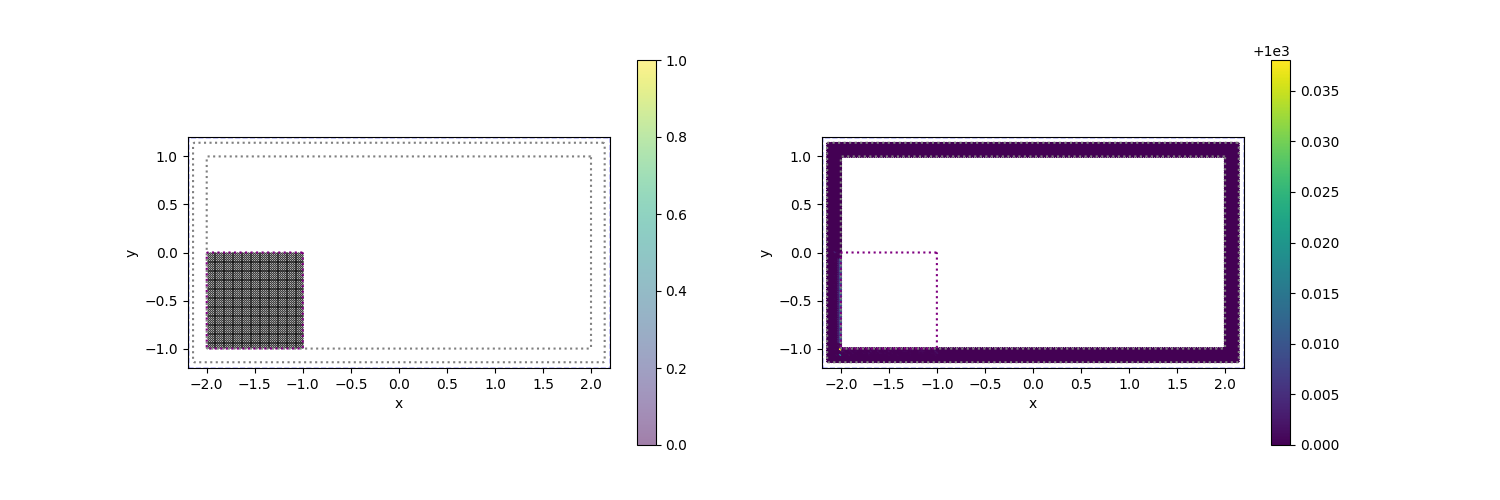

In [21]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])


visualizationState = prepVisualizationState(perennialState, config, grid = True)
boundaryParticlePositions = perennialState['boundary']['positions'] 
# axis[0,0].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = 'black', marker = 'x', s = 2)

boundaryGhostState = buildBoundaryGhostParticles(perennialState, config)
perennialState['boundaryGhost'] = boundaryGhostState
ghostParticlePositions = boundaryGhostState['positions']

boundaryDensity, shepardDensity = mDBCDensity(perennialState, config)

sc = axis[0,0].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), c = 'black', marker = 'x', s = 1, alpha = 0.5)

# sc = axis[0,0].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = boundaryGhostState['numNeighbors'], marker = 'o', s = 2)
# sc = axis[0,0].scatter(ghostParticlePositions[:,0].detach().cpu().numpy(), ghostParticlePositions[:,1].detach().cpu().numpy(), c = 'blue', marker = 'o', s = 2)
fig.colorbar(sc, ax = axis[0,0])
sc = axis[0,1].scatter(boundaryParticlePositions[:,0].detach().cpu().numpy(), boundaryParticlePositions[:,1].detach().cpu().numpy(), c = boundaryDensity.detach().cpu().numpy(), marker = 'x', s = 2)
fig.colorbar(sc, ax = axis[0,1])

In [22]:
state = perennialState   
state['fluid']['neighborhood'] = neighborSearch(state['fluid'], state['fluid'], config, priorNeighborhood = None if 'neighborhood' not in state['fluid'] else state['fluid']['neighborhood'])
_, state['fluid']['numNeighbors'] = countUniqueEntries(state['fluid']['neighborhood']['indices'][0], state['fluid']['positions'])

state['boundaryGhost'] = buildBoundaryGhostParticles(state, config)
state['outletGhost'] = buildOutletGhostParticles(regions, state, config)

if config['boundary']['active']:
    if not config['boundary']['static']:
        state['boundary']['neighborhood'] = neighborSearch(state['boundary'], state['boundary'], config, priorNeighborhood = None if 'neighborhood' not in state['boundary'] else state['boundary']['neighborhood'])
        _, state['boundary']['numNeighbors'] = countUniqueEntries(state['boundary']['neighborhood']['indices'][0], state['boundary']['positions'])
    
    state['boundaryToFluidNeighborhood'] = neighborSearch(state['fluid'], state['boundary'], config, priorNeighborhood = None if 'boundaryToFluidNeighborhood' not in state else state['boundaryToFluidNeighborhood'])
    _, state['boundaryToFluidNumNeighbors'] = countUniqueEntries(state['boundaryToFluidNeighborhood']['indices'][0], state['fluid']['positions'])
    state['fluidToBoundaryNeighborhood'] = neighborSearch(state['boundary'], state['fluid'], config, priorNeighborhood = None if 'fluidToBoundaryNeighborhood' not in state else state['fluidToBoundaryNeighborhood'])
    _, state['fluidToBoundaryNumNeighbors'] = countUniqueEntries(state['fluidToBoundaryNeighborhood']['indices'][0], state['boundary']['positions'])

if config['simulation']['densityScheme'] == 'summation':
    if config['boundary']['active']:
        state['fluid']['densities'], state['boundary']['densities'] = callModule(state, computeDensity, config, 'all')
    else:
        state['fluid']['densities'], _ = callModule(state, computeDensity, config, 'fluid')

state['boundary']['densities'], state['boundaryGhost']['densities'] = mDBCDensity(state, config)

Text(0.5, 0.98, 'Time: 0.00 s, timestep: 0, dt: 1.00e-03 s, particles: 8169 (2809 fluid + 5360 boundary)')

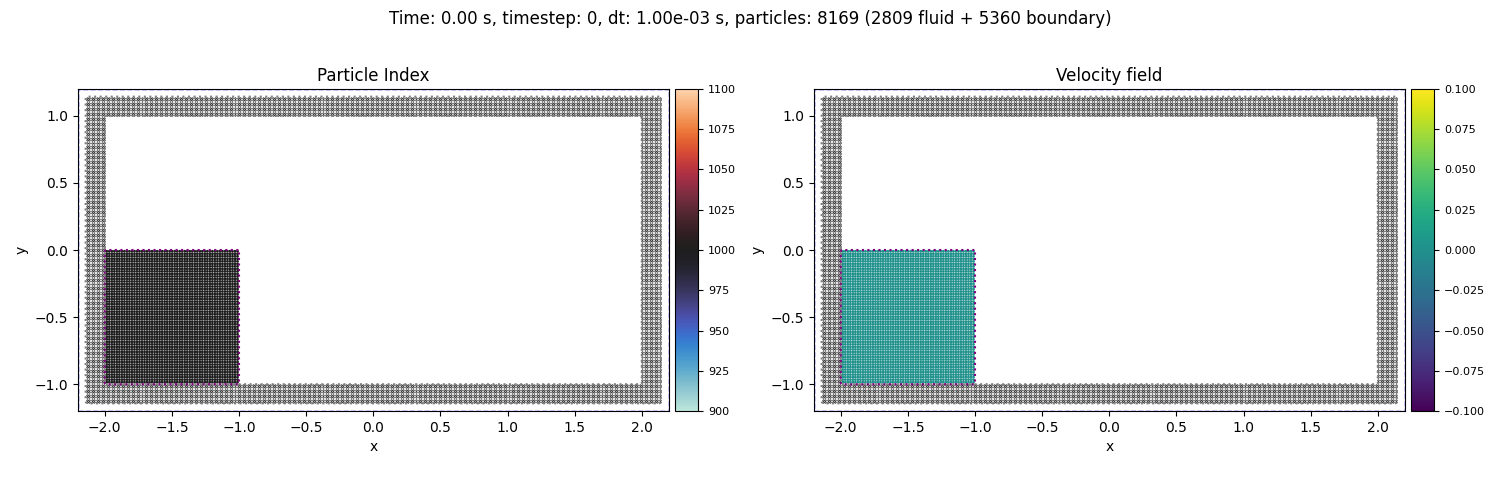

In [23]:
fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
s = 1

visualizationState = prepVisualizationState(perennialState, config, grid = True)
plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'densities', mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle Index', which = 'fluid', plotBoth = False, midPoint = config['fluid']['rho0'])
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field', plotBoth = False)


axis[0,0].scatter(
    perennialState['boundary']['positions'][:,0].detach().cpu().numpy(), 
    perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
    c = 'black',
    marker = 'x',
    s = 1,
    alpha = 0.5)
axis[0,1].scatter(
    perennialState['boundary']['positions'][:,0].detach().cpu() .numpy(), 
    perennialState['boundary']['positions'][:,1].detach().cpu().numpy(), 
    c = 'black',
    marker = 'x',
    s = 1,
    alpha = 0.5)

fig.tight_layout()

fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')

In [24]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
priorState = None
for i in tqdm(range(3000)):
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'] += dx
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    if i % 50 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'densities')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)

    for emitter in regions:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)
        if emitter['type'] == 'forcing':
            processForcing(emitter, config, perennialState)


  0%|          | 0/3000 [00:00<?, ?it/s]

In [206]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

[Parsed_palettegen_2 @ 0x5b4ebefd1d80] Dupped color: FF939393


CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_05_24-15_39_00/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_05_24-15_39_00.gif'], returncode=0)

In [1]:
print("/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i *.png -c:v libx264 -b:v 20M -r 30 'output.mp4")

/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i *.png -c:v libx264 -b:v 20M -r 30 'output.mp4


In [27]:

from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(8)):
        with record_function("timing"): 
            curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            # dx, _ = solveShifting(curState, config)
            # curState['fluid']['shiftAmount'] = dx
            # curState['fluid']['positions'] += dx

        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

STAGE:2024-05-24 10:23:44 1409718:1409718 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/8 [00:00<?, ?it/s]

STAGE:2024-05-24 10:23:50 1409718:1409718 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-24 10:23:50 1409718:1409718 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.06%       3.412ms       100.00%        5.299s     662.416ms      34.94 Mb     -38.42 Mb             8  
                               [Simulation] - Integrate         1.18%      62.796ms        99.94%        5.296s     661.990ms      73.37 Mb     174.91 Mb             8  
                                     [Simulation] - RK4         0.02%       1.100ms        97.82%        5.184s     647.993ms       7.46 Mb           

In [ ]:

print(prof.key_averages().table(sort_by='cpu_time_total'))

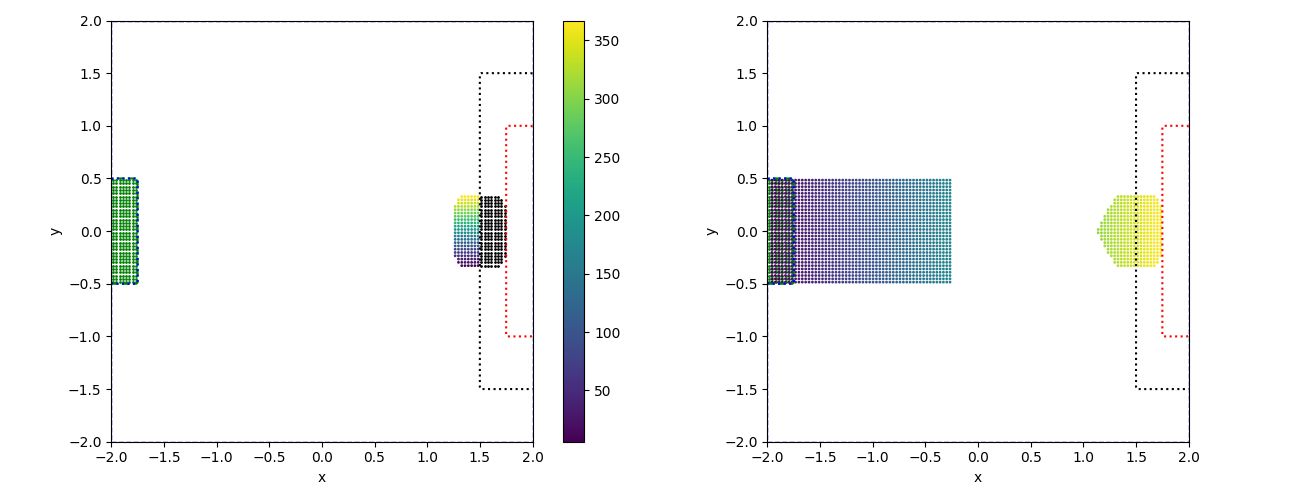

In [ ]:
from diffSPH.v2.plotting import setPlotBaseAttributes

fig, axis = plt.subplots(1, 2, figsize = (13,5), squeeze = False)

setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])
fig.tight_layout()


ghostState = buildOutletGhostParticles(regions, perennialState, config)

if ghostState is not None:

    sc = axis[0,0].scatter(ghostState['positions'][:,0].detach().cpu().numpy(), ghostState['positions'][:,1].detach().cpu().numpy(), s = 1, c = ghostState['fluidIndex'])
    fig.colorbar(sc, ax = axis[0,0])

    ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]

    # axis[0,0].quiver(pos[:,0].detach().cpu().numpy(), pos[:,1].detach().cpu().numpy(), grad[:,0].detach().cpu().numpy(), grad[:,1].detach().cpu().numpy(), color = 'black', scale = 10)

    sc = axis[0,0].scatter(ghostPos[:,0].detach().cpu().numpy(), ghostPos[:,1].detach().cpu().numpy(), s = 1, c = 'black')

q = perennialState['fluid']['positions'][:,0]# * perennialState['fluid']['positions'][:,1]


sc = axis[0,1].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), s = 1, c = q)


In [ ]:
# qfn = lambda x: x[:,0] + x[:,1]

# q = qfn(fluidState['positions'])# + fluidState['positions'][:,1]
# solution, M, b = LiuLiuConsistent(ghostState, fluidState, q)
# print(f'solution: {solution.shape}, min: {solution.min()}, max: {solution.max()}')

# extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:])
# print(f'extrapolated: {extrapolated.shape}, min: {extrapolated.min()}, max: {extrapolated.max()}')

# ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]
# gt = qfn(ghostPos)

# error = extrapolated - gt
# print(f'error: {error.shape}, min: {error.min()}, max: {error.max()}, mean: {error.mean()}')


solution: torch.Size([168, 3]), min: 0.9999753832817078, max: 1.8124845027923584
extrapolated: torch.Size([168]), min: 1.1875139474868774, max: 2.0000178813934326
error: torch.Size([168]), min: -5.4836273193359375e-06, max: 3.2186508178710938e-06, mean: 2.0790668031622772e-07


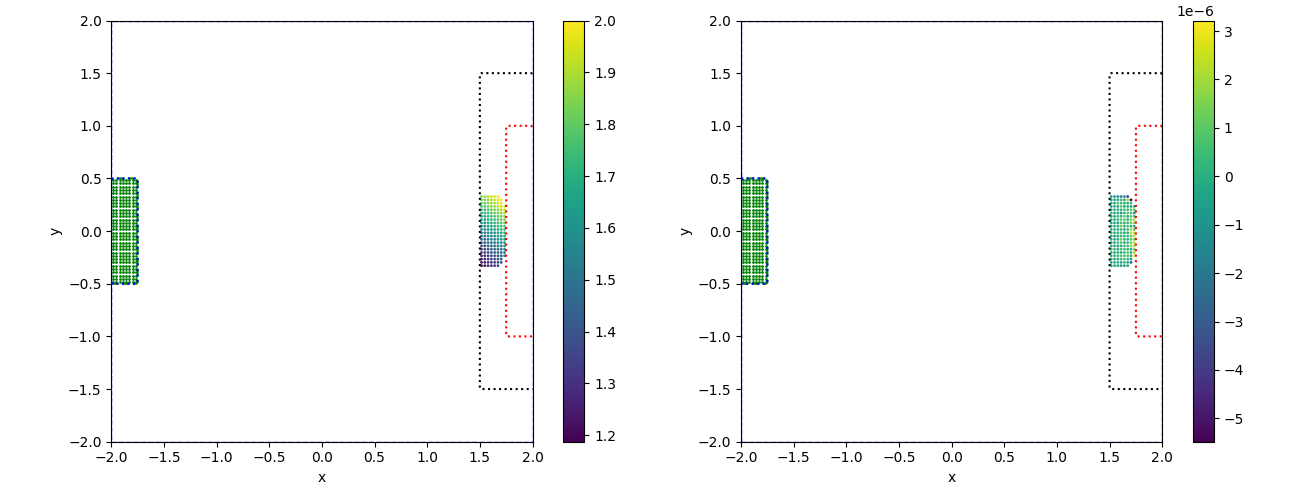

In [ ]:
from diffSPH.v2.plotting import setPlotBaseAttributes

qfn = lambda x: x[:,0] + x[:,1]

q = qfn(fluidState['positions'])# + fluidState['positions'][:,1]
if ghostState is not None:
    solution, M, b = LiuLiuConsistent(ghostState, fluidState, q)
    print(f'solution: {solution.shape}, min: {solution.min()}, max: {solution.max()}')

    extrapolated = solution[:,0] + torch.einsum('nd, nd -> n', ghostState['sdf_dist'][:,None] * ghostState['sdf_grad'] * 2, solution[:,1:])
    print(f'extrapolated: {extrapolated.shape}, min: {extrapolated.min()}, max: {extrapolated.max()}')

    ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]
    gt = qfn(ghostPos)

    error = extrapolated - gt
    print(f'error: {error.shape}, min: {error.min()}, max: {error.max()}, mean: {error.mean()}')


fig, axis = plt.subplots(1, 2, figsize = (13,5), squeeze = False)

setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)

plotRegions(regions, axis[0,0])
plotRegions(regions, axis[0,1])
fig.tight_layout()


ghostState = buildOutletGhostParticles(regions, perennialState, config)

if ghostState is not None:

    # sc = axis[0,0].scatter(ghostState['positions'][:,0].detach().cpu().numpy(), ghostState['positions'][:,1].detach().cpu().numpy(), s = 1, c = b[:,0])
    # fig.colorbar(sc, ax = axis[0,0])

    # ghostPos = perennialState['fluid']['positions'][ghostState['fluidIndex']]

    # axis[0,0].quiver(pos[:,0].detach().cpu().numpy(), pos[:,1].detach().cpu().numpy(), grad[:,0].detach().cpu().numpy(), grad[:,1].detach().cpu().numpy(), color = 'black', scale = 10)

    sc = axis[0,0].scatter(ghostPos[:,0].detach().cpu().numpy(), ghostPos[:,1].detach().cpu().numpy(), s = 1, c = extrapolated)
    fig.colorbar(sc, ax = axis[0,0])

    q = perennialState['fluid']['positions'][:,0]# * perennialState['fluid']['positions'][:,1]


    sc = axis[0,1].scatter(ghostPos[:,0].detach().cpu().numpy(), ghostPos[:,1].detach().cpu().numpy(), s = 1, c = extrapolated - gt)
    fig.colorbar(sc, ax = axis[0,1])
# sc = axis[0,1].scatter(perennialState['fluid']['positions'][:,0].detach().cpu().numpy(), perennialState['fluid']['positions'][:,1].detach().cpu().numpy(), s = 1, c = q)


In [ ]:

for i in tqdm(range(1500)):
    # perennialState = simulationStep(perennialState, config)
    perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    if i % 50 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'index')
        updatePlot(quantPlot, visualizationState, 'velocities')
        fig.canvas.draw()
        fig.canvas.flush_events()

    for emitter in regions:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)

    # emitterNeighborhood = neighborSearch(emitterPositions, perennialState['fluid'], config, computeKernels=False)

    # distance = emitterNeighborhood['distances']
    # i = emitterNeighborhood['indices'][0]
    # newDistance = distance.new_ones(emitterPositions['numParticles'], dtype = config['compute']['dtype']) #* config['particle']['support']
    # minDistance = newDistance.index_reduce_(dim = 0, index = i, source = distance, include_self = False, reduce = 'amin')

    # emitterMask = minDistance >= config['particle']['dx'] / config['particle']['support']

    # newPositions = emitterPositions['positions'][emitterMask].to(config['compute']['device'])
    # newParticleState = {
    #     'numParticles': newPositions.shape[0],
    #     'positions': newPositions,

    #     'areas': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'],
    #     'masses': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['volume'] * config['fluid']['rho0'],
    #     'densities': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['fluid']['rho0'],
    #     'supports': torch.ones(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']) * config['particle']['support'],

    #     'pressures': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'divergence': torch.zeros(newPositions.shape[0], dtype = config['compute']['dtype'], device = config['compute']['device']),

    #     'velocities': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'accelerations': torch.zeros(newPositions.shape, dtype = config['compute']['dtype'], device = config['compute']['device']),
    #     'index': torch.arange(newPositions.shape[0], dtype = torch.int32, device = config['compute']['device']) + perennialState['uidCounter'],
    #     # 'neighbors': None,
    # }
    # newParticleState['velocities'][:,0] = u
    # # print(f'Adding {newParticleState["numParticles"]} particles (total {perennialState["fluid"]["numParticles"] + newParticleState["numParticles"]})')
    # perennialState['uidCounter'] += newParticleState['numParticles']

    # perennialState['fluid'] = mergeStates(perennialState['fluid'], newParticleState)


# visualizationState = prepVisualizationState(perennialState, config)
# updatePlot(indexPlot, visualizationState, 'index')
# updatePlot(quantPlot, visualizationState, 'densities')

  0%|          | 0/1500 [00:00<?, ?it/s]

Outlet: 2 particles removed
Current particles: 2032
torch.Size([2030]) tensor([   0,    1,    2,  ..., 2029, 2030, 2031])
Outlet: 6 particles removed
Current particles: 2062
torch.Size([2056]) tensor([   0,    1,    2,  ..., 2059, 2060, 2061])
Outlet: 10 particles removed
Current particles: 2088
torch.Size([2078]) tensor([   0,    1,    2,  ..., 2085, 2086, 2087])
Outlet: 14 particles removed
Current particles: 2110
torch.Size([2096]) tensor([   0,    1,    2,  ..., 2107, 2108, 2109])


In [ ]:
emitterPositions

{'numParticles': 1560,
 'positions': tensor([[-0.1953, -0.3203],
         [-0.1797, -0.3203],
         [-0.1641, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1557, 1558, 1559], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'accele

In [ ]:
config['particle']

{'nx': 128,
 'dx': tensor(0.0156, device='cuda:0'),
 'support': tensor(0.0593, device='cuda:0'),
 'defaultVolume': tensor(0.0002, device='cuda:0'),
 'defaultSupport': tensor(0.0593, device='cuda:0'),
 'volume': tensor(0.0002, device='cuda:0'),
 'smoothingLength': tensor(0.0312, device='cuda:0')}

1560 1434


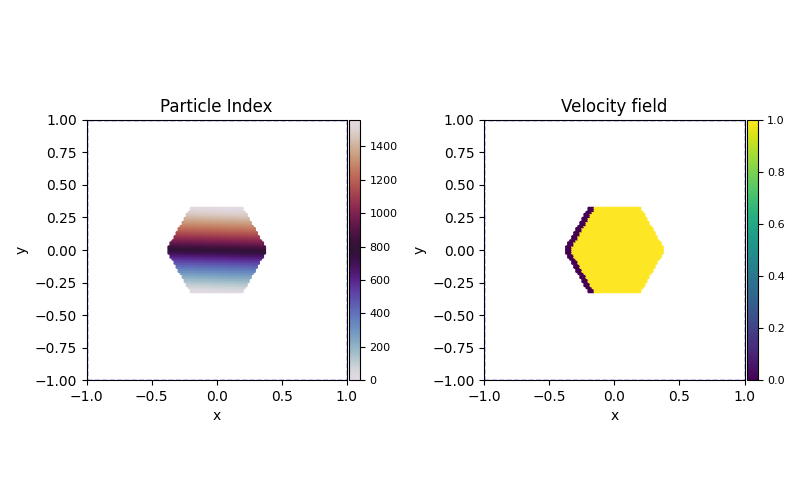

In [ ]:
fig, axis = plt.subplots(1,2, figsize = (8,5), squeeze = False)

s = 2
emitterState = {
    'fluid': copy.deepcopy(emitterPositions),
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
}

u = 1
perennialState['fluid']['velocities'][:,0] = u

visualizationState = prepVisualizationState(emitterState, config)

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity = 'index', mapping = '.x', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = emitterMask, mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Velocity field')

fig.tight_layout()

{'numParticles': 7296,
 'positions': tensor([[-0.1453, -0.3203],
         [-0.1297, -0.3203],
         [-0.1141, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1431, 1432, 1433], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [1., 0.],
         [1., 0.],
         [1., 0.]], device='cuda:0'),
 'accele

In [ ]:
emitterPositions

{'numParticles': 1560,
 'positions': tensor([[-0.1953, -0.3203],
         [-0.1797, -0.3203],
         [-0.1641, -0.3203],
         ...,
         [ 0.1641,  0.3203],
         [ 0.1797,  0.3203],
         [ 0.1953,  0.3203]], device='cuda:0'),
 'areas': tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0'),
 'pressures': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'divergence': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'),
 'masses': tensor([0.2441, 0.2441, 0.2441,  ..., 0.2441, 0.2441, 0.2441], device='cuda:0'),
 'supports': tensor([0.0593, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0593], device='cuda:0'),
 'index': tensor([   0,    1,    2,  ..., 1557, 1558, 1559], device='cuda:0'),
 'densities': tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.], device='cuda:0'),
 'velocities': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'accele

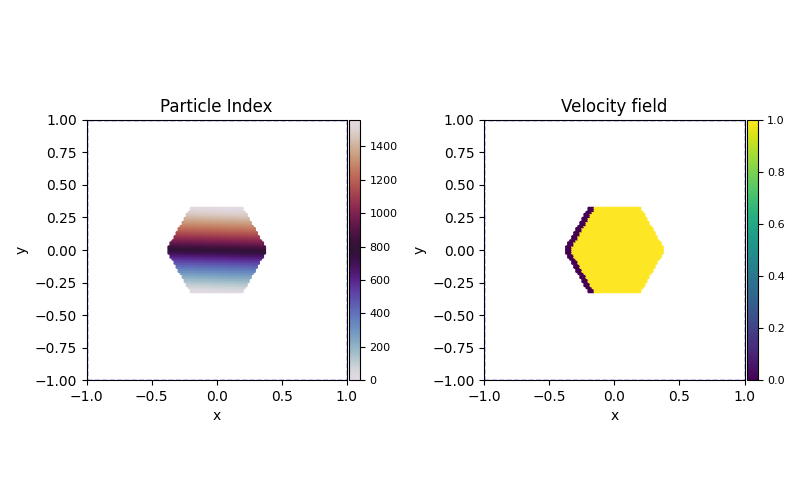

In [ ]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

particleState, mask = sampleParticles(config, sdfs = [sdf])

priorState = None
# particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
# particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])
particleState['velocities'][:,0] =  1 
particleState['velocities'][:,1] = 0

u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()

# perennialState = {
#     'fluid': copy.deepcopy(particleState),
#     'time': 0.0,
#     'timestep': 0,
#     'dt': config['timestep']['dt'],
# }
# del particleState['neighborhood']


In [ ]:
# from diffSPH.v2.plotting import computePSD, plotFFT, plotPSD, mapToGrid, visualizeParticleQuantity

# s = 2

# fig, axis = plt.subplot_mosaic('''AB''', figsize=(10.5,5), sharex = False, sharey = False)

# visualizationState = prepVisualizationState(perennialState, config)

# visualizeParticleQuantity(fig, axis['A'], config, visualizationState, quantity = 'index', mapping = '.x', s = s, 
#                           scaling = 'lin', gridVisualization=False, cmap = 'twilight', title = 'Particle Index')
# visualizeParticleQuantity(fig, axis['B'], config, visualizationState, quantity = 'velocities', mapping = 'L2', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = True, operation = None, title = 'Velocity field')

# E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
# E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
# nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
# Re = u_mag * 2 / nu_total

# fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

# fig.tight_layout()

In [ ]:
# torch.cuda.memory._record_memory_history(max_entries=100000)

Setting up initial plot
Computing visualization state
Setting up plot A
Setting up plot B
Done setting up initial plot


0.0000%|          | 0/1 [00:00<?] ?it/s

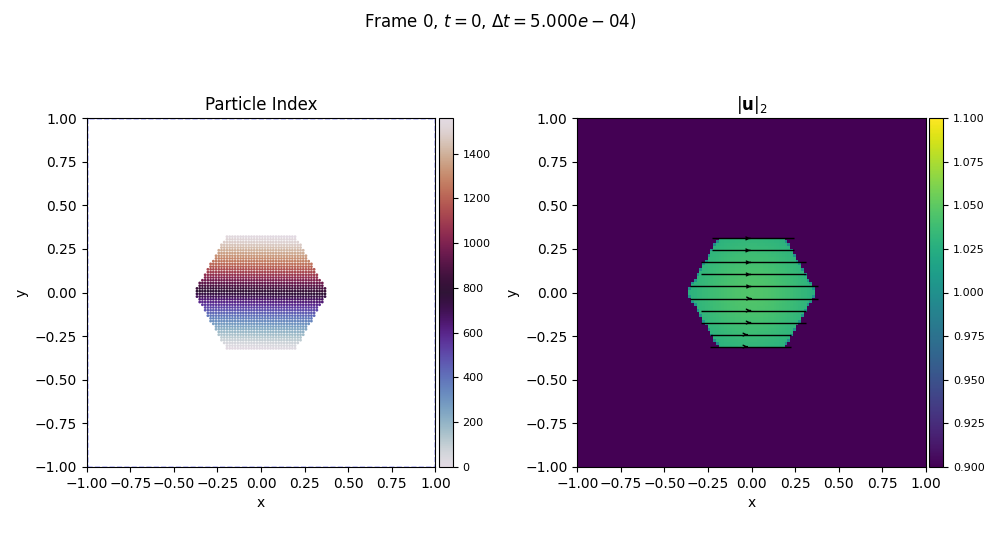

In [ ]:
from diffSPH.v2.plotting import updatePlots
from diffSPH.v2.runner import runSimulation, setupSimulation

def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    pass
    # E_k = perennialState['fluid']['E_k']
    # nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    # Re = u_mag * 2 / nu_total
    # title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

config['timestep']['active'] = False
config['timestep']['dt'] = 5e-4
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

perennialState, fig, axis, plotStates, priorState, pbar, stats = setupSimulation(initialState, config, stepLimit = -1, timeLimit = 1)

# E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
# E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
# nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
# Re = u_mag * 2 / nu_total

# title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')
fig.tight_layout()

# updatePlots(perennialState, particleState, config, plotStates, fig, axis)

In [ ]:

stat, pstate = runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = -1, timeLimit = 1, callBack = None)
# 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x795dc6e18b50>>
Traceback (most recent call last):
  File "/home/winchenbach/anaconda3/envs/torch_22/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# torch.cuda.memory._dump_snapshot('dump.pth')

In [ ]:
config['shifting']

{'scheme': 'deltaSPH',
 'threshold': 0.05,
 'maxIterations': 1,
 'freeSurface': False,
 'R': 0.25,
 'n': 4,
 'CFL': 1.5,
 'computeMach': True,
 'solver': 'BiCGStab_wJacobi',
 'normalScheme': 'lambda',
 'projectionScheme': 'mat',
 'surfaceScaling': 0.1,
 'summationDensity': False,
 'useExtendedMask': False,
 'initialization': 'zero',
 'maxSolveIter': 64,
 'surfaceDetection': 'Barcasco',
 'active': True}

In [ ]:

from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(32)):
        with record_function("timing"): 
            curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            dx, _ = solveShifting(curState, config)
            curState['fluid']['shiftAmount'] = dx
            curState['fluid']['positions'] += dx

        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

STAGE:2024-05-22 11:06:28 1367417:1367417 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/32 [00:00<?, ?it/s]

STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [ ]:

print(prof.key_averages().table(sort_by='cuda_time_total'))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [ ]:
def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    perennialState['fluid']['E_k']
    nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    Re = u_mag * 2 / nu_total
    title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

    

def runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = 1000, timeLimit = -1, callBack = None):
    # for i in tqdm(range(1000)):
    frameStatistics = computeStatistics(perennialState, particleState, config)
    stats.append(frameStatistics)
    if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
        updatePlots(perennialState, particleState, config, plotStates, fig, axis)
    if config['export']['active']:
        f, simulationDataGroup = createOutputFile(config)
        
    lastUpdate = perennialState['time']
    while(True):
        perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
        # Particle shifting
        dx, _ = solveShifting(perennialState, config)
        perennialState['fluid']['shiftAmount'] = dx
        perennialState['fluid']['positions'] += dx
        # Frame done, update state for next timestep
        perennialState['dt'] = config['timestep']['dt']
        perennialState['fluid']['Eks'] = (0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2)
        perennialState['fluid']['E_k'] = perennialState['fluid']['Eks'].sum().detach().cpu().item()
        frameStatistics = computeStatistics(perennialState, particleState, config)
        
        if config['export']['active']:
            if perennialState['timestep'] % config['export']['interval'] == 0:
                writeFrame(simulationDataGroup, perennialState, priorState, frameStatistics, config)

        
        perennialState['time'] += config['timestep']['dt']
        perennialState['timestep'] += 1

        config['timestep']['dt'] = computeTimestep(perennialState, config)
        time = perennialState['time']
        dt = config['timestep']['dt']

        if timeLimit > 0:
            pbar.n = time.detach().cpu().item() if isinstance(time, torch.Tensor) else time
            pbar.refresh()
        else: 
            pbar.n = perennialState['timestep']
            pbar.refresh()
        if perennialState['time'] > timeLimit and timeLimit > 0:
            break
        if perennialState['timestep'] > stepLimit and stepLimit > 0:
            break



        ttime = perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item()
        stats.append(frameStatistics)

        if callBack is not None:
            callBack(perennialState, particleState, config, plotStates, fig, axis, frameStatistics)
        if config['plot']['fps'] > 0:
            if perennialState['time'] > lastUpdate + 1 / config['plot']['fps']:
                lastUpdate = ttime
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)
        else:
            if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)

    pbar.close()
    if config['export']['active']:
        f.close()

    postProcessPlot(config)
    return stats, perennialState